In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


Libraries

In [2]:
import os
import time
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, roc_curve
import matplotlib.pyplot as plt

Paths & Settings

In [3]:
DATASET_PATH = "/content/drive/MyDrive/CMPE 593/datasets/processed_datasets/NTHU-DDD"
TRAIN_DIR = os.path.join(DATASET_PATH, "train")
VAL_DIR   = os.path.join(DATASET_PATH, "val")
TEST_DIR  = os.path.join(DATASET_PATH, "test")

In [4]:
IMG_SIZE = (224, 224)
BATCH_SIZE = 32
SEED = 42
class_names = ["notdrowsy", "drowsy"]

In [5]:
AUTOTUNE = tf.data.AUTOTUNE

Dataset Loader

In [6]:
def make_dataset(directory, shuffle, batch_size=BATCH_SIZE):
    ds = tf.keras.preprocessing.image_dataset_from_directory(
        directory,
        labels="inferred",
        label_mode="int",
        image_size=IMG_SIZE,
        batch_size=batch_size,
        shuffle=shuffle,
        seed=SEED,
        class_names=class_names,
    )
    ds = ds.cache().prefetch(AUTOTUNE)
    return ds


train_ds = make_dataset(TRAIN_DIR, shuffle=True)
val_ds   = make_dataset(VAL_DIR, shuffle=False)
test_ds  = make_dataset(TEST_DIR, shuffle=False)


Found 46564 files belonging to 2 classes.
Found 9978 files belonging to 2 classes.
Found 9979 files belonging to 2 classes.


Data Augmentation

In [7]:
data_augmentation = keras.Sequential(
    [
        layers.RandomFlip("horizontal"),
        layers.RandomRotation(0.05),
        layers.RandomZoom(0.1),
        layers.RandomBrightness(0.1),
    ],
    name="data_augmentation",
)

Build EfficientNetB0 Model

In [8]:
base_model = keras.applications.EfficientNetB0(
    include_top=False,
    weights="imagenet",
    input_shape=(IMG_SIZE[0], IMG_SIZE[1], 3),
    pooling="avg",
)

base_model.trainable = False   # Stage 1: freeze

inputs = keras.Input(shape=(IMG_SIZE[0], IMG_SIZE[1], 3))
x = data_augmentation(inputs)
x = keras.applications.efficientnet.preprocess_input(x)
x = base_model(x, training=False)
x = layers.Dropout(0.3)(x)
outputs = layers.Dense(1, activation="sigmoid")(x)

model = keras.Model(inputs, outputs)
model.summary()

16705208/16705208 ━━━━━━━━━━━━━━━━━━━━ 2s 0us/step


Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)      │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ data_augmentation (Sequential)  │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ efficientnetb0 (Functional)     │ (None, 1280)           │     4,049,571 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 1280)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1)              │         1,281 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 4,050,852 (15.45 MB)

 Trainable params: 1,281 (5.00 KB)

 Non-trainable params: 4,049,571 (15.45 MB)

Epoch Timing Callback

In [9]:
class EpochTimer(tf.keras.callbacks.Callback):
    def on_epoch_begin(self, epoch, logs=None):
        self.start = time.time()
    def on_epoch_end(self, epoch, logs=None):
        print(f"\nEpoch {epoch+1} Time: {time.time() - self.start:.2f} sec")


timer = EpochTimer()


Callbacks

In [10]:
best_model_path = os.path.join(DATASET_PATH, "efficientnetb0_best.keras")

callbacks = [
    timer,
    keras.callbacks.EarlyStopping(monitor="val_loss", patience=3, restore_best_weights=True),
    keras.callbacks.ModelCheckpoint(best_model_path, monitor="val_loss", save_best_only=True),
    keras.callbacks.ReduceLROnPlateau(monitor="val_loss", factor=0.5, patience=2),
]

Training — Stage 1 (Frozen Base)

In [11]:
total_start = time.time()

model.compile(
    optimizer=keras.optimizers.Adam(1e-4),
    loss="binary_crossentropy",
    metrics=["accuracy", keras.metrics.Precision(), keras.metrics.Recall(), keras.metrics.AUC()],
)

EPOCHS_STAGE1 = 5

print("\n======== Stage 1: Training classifier head ========\n")
history1 = model.fit(train_ds, validation_data=val_ds, epochs=EPOCHS_STAGE1, callbacks=callbacks)



======== Stage 1: Training classifier head ========

Epoch 1/5
1456/1456 ━━━━━━━━━━━━━━━━━━━━ 0s 4s/step - accuracy: 0.5734 - auc: 0.5904 - loss: 0.6772 - precision: 0.5841 - recall: 0.7427
Epoch 1 Time: 6428.49 sec
1456/1456 ━━━━━━━━━━━━━━━━━━━━ 6434s 4s/step - accuracy: 0.5734 - auc: 0.5904 - loss: 0.6771 - precision: 0.5841 - recall: 0.7427 - val_accuracy: 0.7602 - val_auc: 0.8571 - val_loss: 0.5985 - val_precision: 0.7108 - val_recall: 0.9393 - learning_rate: 1.0000e-04
Epoch 2/5
1456/1456 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - accuracy: 0.6850 - auc: 0.7477 - loss: 0.6116 - precision: 0.6756 - recall: 0.8060
Epoch 2 Time: 34.84 sec
1456/1456 ━━━━━━━━━━━━━━━━━━━━ 36s 24ms/step - accuracy: 0.6850 - auc: 0.7477 - loss: 0.6116 - precision: 0.6756 - recall: 0.8060 - val_accuracy: 0.7913 - val_auc: 0.8803 - val_loss: 0.5510 - val_precision: 0.7534 - val_recall: 0.9138 - learning_rate: 1.0000e-04
Epoch 3/5
1456/1456 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - accuracy: 0.7193 - auc: 0.7918 - loss:

Training — Stage 2 (Fine-Tuning)

In [12]:
print("\n======== Stage 2: Fine-Tuning ========\n")

# unfreeze final 30% of layers
fine_tune_at = len(base_model.layers) * 7 // 10
for layer in base_model.layers[fine_tune_at:]:
    layer.trainable = True

model.compile(
    optimizer=keras.optimizers.Adam(1e-5),
    loss="binary_crossentropy",
    metrics=["accuracy", keras.metrics.Precision(), keras.metrics.Recall(), keras.metrics.AUC()],
)

EPOCHS_STAGE2 = 10
history2 = model.fit(train_ds, validation_data=val_ds, epochs=EPOCHS_STAGE2, callbacks=callbacks)



======== Stage 2: Fine-Tuning ========

Epoch 1/10
1455/1456 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step - accuracy: 0.7511 - auc_1: 0.8245 - loss: 0.5033 - precision_1: 0.7672 - recall_1: 0.7715
Epoch 1 Time: 77.83 sec
1456/1456 ━━━━━━━━━━━━━━━━━━━━ 79s 41ms/step - accuracy: 0.7512 - auc_1: 0.8246 - loss: 0.5032 - precision_1: 0.7673 - recall_1: 0.7717 - val_accuracy: 0.8685 - val_auc_1: 0.9543 - val_loss: 0.2901 - val_precision_1: 0.8204 - val_recall_1: 0.9695 - learning_rate: 1.0000e-05
Epoch 2/10
1455/1456 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step - accuracy: 0.8696 - auc_1: 0.9465 - loss: 0.2905 - precision_1: 0.8562 - recall_1: 0.9129
Epoch 2 Time: 56.08 sec
1456/1456 ━━━━━━━━━━━━━━━━━━━━ 57s 39ms/step - accuracy: 0.8696 - auc_1: 0.9465 - loss: 0.2904 - precision_1: 0.8562 - recall_1: 0.9129 - val_accuracy: 0.9013 - val_auc_1: 0.9661 - val_loss: 0.2396 - val_precision_1: 0.9005 - val_recall_1: 0.9193 - learning_rate: 1.0000e-05
Epoch 3/10
1455/1456 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step - accuracy: 0.

Total Training Time

In [13]:
print(f"\nTotal Training Time: {(time.time() - total_start)/60:.2f} minutes\n")


Total Training Time: 119.50 minutes



In [14]:
# -------------------------------------------------
# SAFE Combine histories from Stage 1 & Stage 2
# -------------------------------------------------
def combine_histories(h1, h2):
    history = {}
    all_keys = set(h1.history.keys()).union(set(h2.history.keys()))

    for key in all_keys:
        vals1 = h1.history.get(key, [])
        vals2 = h2.history.get(key, [])
        history[key] = vals1 + vals2

    return history

full_history = combine_histories(history1, history2)
epochs_range = range(1, len(full_history["loss"]) + 1)


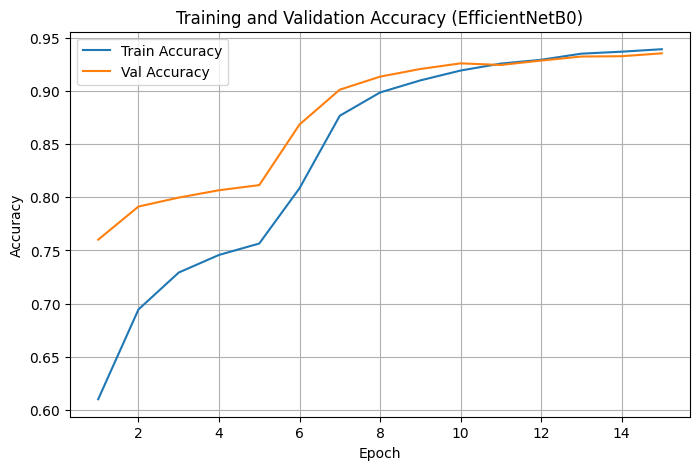

In [15]:
# -------------------------------------------------
# Training & Validation Accuracy Plot
# -------------------------------------------------
plt.figure(figsize=(8, 5))
plt.plot(epochs_range, full_history['accuracy'], label='Train Accuracy')
plt.plot(epochs_range, full_history['val_accuracy'], label='Val Accuracy')
plt.title('Training and Validation Accuracy (EfficientNetB0)')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)
plt.show()

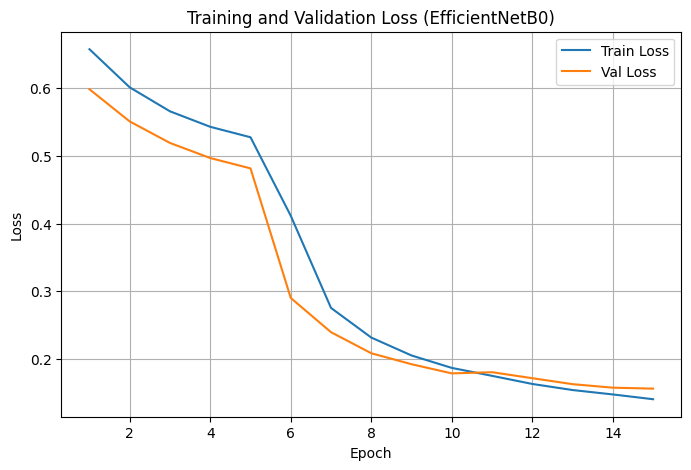

In [16]:
# -------------------------------------------------
# Training & Validation Loss Plot
# -------------------------------------------------
plt.figure(figsize=(8, 5))
plt.plot(epochs_range, full_history['loss'], label='Train Loss')
plt.plot(epochs_range, full_history['val_loss'], label='Val Loss')
plt.title('Training and Validation Loss (EfficientNetB0)')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()

In [17]:
print(full_history.keys())

dict_keys(['val_recall', 'recall', 'auc', 'loss', 'val_precision_1', 'accuracy', 'auc_1', 'val_auc', 'learning_rate', 'val_auc_1', 'precision_1', 'precision', 'val_precision', 'recall_1', 'val_recall_1', 'val_loss', 'val_accuracy'])


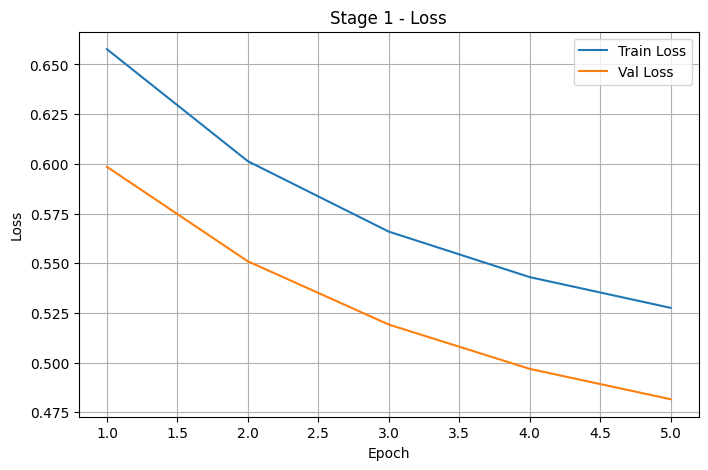

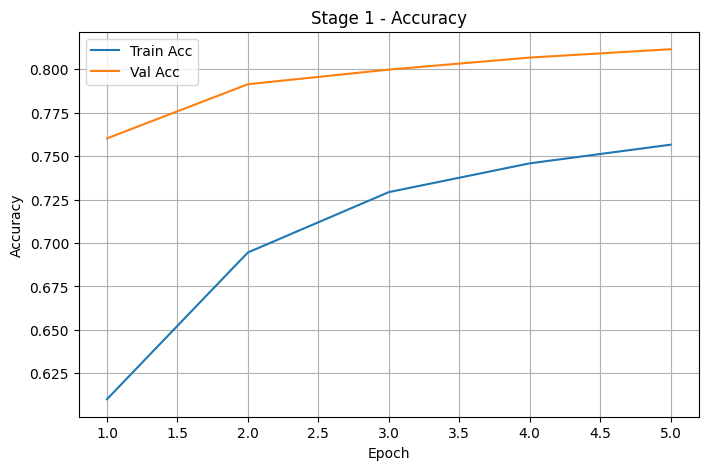

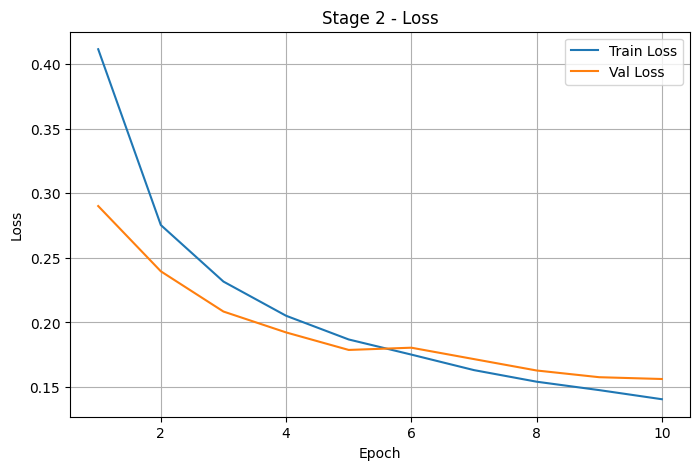

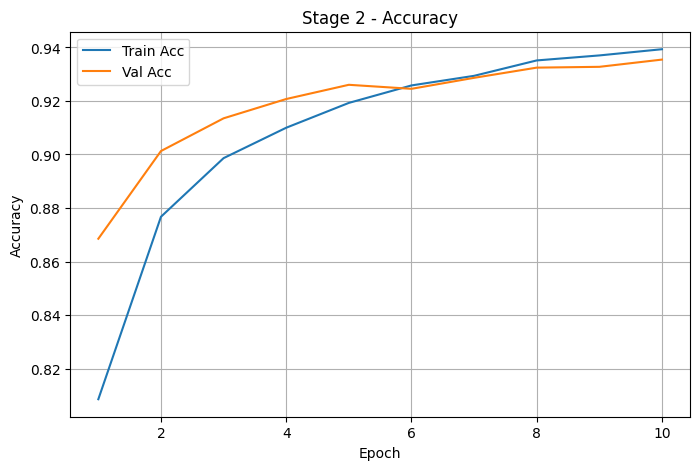

In [18]:
# -------------------------------------------------
# Plot Stage 1 Metrics
# -------------------------------------------------
def plot_stage_history(history, stage_name):
    hist = history.history
    epochs = range(1, len(hist["loss"]) + 1)

    # Loss
    plt.figure(figsize=(8,5))
    plt.plot(epochs, hist["loss"], label="Train Loss")
    plt.plot(epochs, hist["val_loss"], label="Val Loss")
    plt.title(f"{stage_name} - Loss")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.legend()
    plt.grid(True)
    plt.show()

    # Accuracy
    if "accuracy" in hist:
        plt.figure(figsize=(8,5))
        plt.plot(epochs, hist["accuracy"], label="Train Acc")
        plt.plot(epochs, hist["val_accuracy"], label="Val Acc")
        plt.title(f"{stage_name} - Accuracy")
        plt.xlabel("Epoch")
        plt.ylabel("Accuracy")
        plt.legend()
        plt.grid(True)
        plt.show()

# Plot Stage 1
plot_stage_history(history1, "Stage 1")

# Plot Stage 2
plot_stage_history(history2, "Stage 2")


Total Training Time

In [19]:
print(f"\nTotal Time: {(time.time() - total_start)/60:.2f} minutes\n")


Total Time: 119.51 minutes



Evaluation on Test Set

In [20]:
print("\n======== Test Evaluation ========\n")

test_results = model.evaluate(test_ds, verbose=1)
print(dict(zip(model.metrics_names, test_results)))


======== Test Evaluation ========

312/312 ━━━━━━━━━━━━━━━━━━━━ 1097s 4s/step - accuracy: 0.9319 - auc_1: 0.5392 - loss: 0.1630 - precision_1: 0.4328 - recall_1: 0.5281
{'loss': 0.15133091807365417, 'compile_metrics': 0.9375689029693604}


In [21]:
print("\n======== Computing AUC (scikit-learn) ========\n")

y_true = []
for _, labels in test_ds:
    y_true.extend(labels.numpy())
y_true = np.array(y_true)

y_pred_probs = model.predict(test_ds).ravel()

auc = roc_auc_score(y_true, y_pred_probs)
print("AUC:", auc)


======== Computing AUC (scikit-learn) ========

312/312 ━━━━━━━━━━━━━━━━━━━━ 9s 22ms/step
AUC: 0.98649516007098


ROC Curve

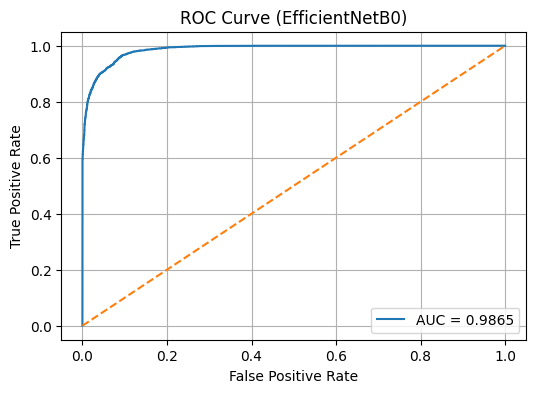

In [22]:
fpr, tpr, _ = roc_curve(y_true, y_pred_probs)
plt.figure(figsize=(6,4))
plt.plot(fpr, tpr, label=f"AUC = {auc:.4f}")
plt.plot([0,1], [0,1], '--')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve (EfficientNetB0)")
plt.legend()
plt.grid(True)
plt.show()

Classification Report + Confusion Matrix


In [23]:
print("\n======== Classification Report ========\n")
y_pred = (y_pred_probs >= 0.5).astype(int)
print(classification_report(y_true, y_pred, target_names=class_names))

print("\nConfusion Matrix:")
print(confusion_matrix(y_true, y_pred))


======== Classification Report ========

              precision    recall  f1-score   support

   notdrowsy       0.95      0.91      0.93      4574
      drowsy       0.93      0.96      0.94      5405

    accuracy                           0.94      9979
   macro avg       0.94      0.94      0.94      9979
weighted avg       0.94      0.94      0.94      9979


Confusion Matrix:
[[4159  415]
 [ 208 5197]]


Inference Time

In [24]:
print("\n======== Inference Timing ========\n")

sample_batch = next(iter(test_ds))
sample_img = tf.expand_dims(sample_batch[0][0], axis=0)

# warm up
_ = model.predict(sample_img)

start = time.time()
for _ in range(50):
    _ = model.predict(sample_img)
end = time.time()

print(f"Average inference per image: {(end-start)/50 * 1000:.2f} ms")



======== Inference Timing ========

1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━

Save final model

In [25]:
final_model_path = os.path.join(DATASET_PATH, "efficientnetb0_final.keras")
model.save(final_model_path)
print("\nSaved final model to:", final_model_path)
print("Best checkpoint saved to:", best_model_path)


Saved final model to: /content/drive/MyDrive/CMPE 593/datasets/processed_datasets/NTHU-DDD/efficientnetb0_final.keras
Best checkpoint saved to: /content/drive/MyDrive/CMPE 593/datasets/processed_datasets/NTHU-DDD/efficientnetb0_best.keras
